## 1. Setup and Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_probability as tfp
tfd = tfp.distributions

# Import acoustic model functions
import sys
sys.path.append('..')
from acoustic_function import (
    initialize_acoustic_model,
    state_transition,
    observation_model,
    observation_model_general,
    compute_observation_jacobian,
    simulate_trajectory
)

from prove_function import (
    compute_lambda_steps,
    initialize_particles,
    propagate_particles,
    estimate_covariance,
    particle_estimate,
    propagateAndEstimatePriorCovariance,
    compute_flow_parameters,
    particle_flow_edh,
    log_proposal_density,
    log_process_density,
    log_likehood_density,
    correctoinAndCalculateWeights,
    force_resample
    
)

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {len(tf.config.list_physical_devices('GPU')) > 0}")

TensorFlow version: 2.20.0
GPU available: False


## 2. Initialize Acoustic Model

In [2]:
# Initialize acoustic model with default parameters (4 targets, 25 sensors)
model_params = initialize_acoustic_model(n_targets=4)

print(f"Configuration:")
print(f"  Targets: {model_params['n_targets']}")
print(f"  Sensors: {model_params['n_sensors']} (5×5 grid)")
print(f"  State dimension: {model_params['state_dim']}")
print(f"  Surveillance area: {model_params['sim_area_size']}m × {model_params['sim_area_size']}m")
print(f"\nAcoustic Parameters:")
print(f"  Amplitude (Ψ): {model_params['amplitude'].numpy()}")
print(f"  Measurement noise std: {model_params['measurement_noise_std']}")

Configuration:
  Targets: 4
  Sensors: 25 (5×5 grid)
  State dimension: 16
  Surveillance area: 40.0m × 40.0m

Acoustic Parameters:
  Amplitude (Ψ): 10.0
  Measurement noise std: 0.1


## 4. Generate Ground Truth Data

In [3]:
# Generate ground truth trajectory and measurements
T = 20  # Number of time steps
ground_truth, measurements = simulate_trajectory(model_params, T, keep_in_bounds=True)

In [4]:
use_ledh = False

In [5]:
T = tf.shape(measurements)[1].numpy()
state_dim = model_params['state_dim']

filter_name = "PFPF-LEDH" if use_ledh else "PFPF-EDH"
n_particle=500
n_lambda=29 
lambda_ratio=1.2

# Pre-compute lambda steps
lambda_steps, lambda_values = compute_lambda_steps(n_lambda, lambda_ratio)
# Algorithm Lines 1-2: Initialize particles and weights
particles, weights, m0, P = initialize_particles(model_params, n_particle)
x_est = m0  # Initial state estimate

vg = {}
vg['M'] = m0
vg['PU'] = P
vg['xp_m'] = m0
vg['particles'] = particles
vg['logW'] = tf.math.log(weights)

estimates_list = []
particles_list = []
weights_list = []
log_jacobian_det_sum = 0

for t in range(T):
    if (t + 1) % 10 == 0:
        print(f"  Step {t+1}/{T}")
    
    
    z_t = tf.expand_dims(measurements[:, t], 1)  # (n_sensor, 1)
    n_particle = tf.shape(particles)[1].numpy()
    state_dim = model_params['state_dim']
    measurement = z_t
    x_est_prev = x_est
    vg = propagateAndEstimatePriorCovariance(x_est_prev, vg, model_params)
    particles_flowed = particle_flow_edh(vg, model_params, measurement, lambda_steps, lambda_values)

    # line 19 - 25
    ml_weights, partilcles_mean = correctoinAndCalculateWeights(particles_flowed, 
                                                                vg,
                                                                measurement, 
                                                                log_jacobian_det_sum, 
                                                                model_params)
    
    vg['xp_m'] = partilcles_mean
    vg['particles_m'] = partilcles_mean
    # line 26
    vg['PU'] = estimate_covariance(particles_flowed) 
    partciles_resample, weights_resample, eff = force_resample(particles_flowed, ml_weights)
    particles = partciles_resample
    vg['logW'] = weights_resample

    estimates_list.append(partilcles_mean)

  Step 10/20
  Step 20/20


In [6]:
estimates = tf.stack(estimates_list, axis=1)

## 5. Run PFPF Filters

Now we run both versions of the filter.

In [7]:
# Run PFPF-EDH filter WITHOUT weights (pure flow like original EDH)
print("="*60)
print("Testing PFPF without importance weights (pure flow)")
print("="*60)
# pfpf_edh_estimates_no_weights, pfpf_edh_particles_no_weights, pfpf_edh_weights_no_weights = run_pfpf_filter(
#     measurements=measurements,
#     model_params=model_params,
#     n_particle=100,
#     n_lambda=20,
#     lambda_ratio=1.2,
#     use_ledh=False,  # EDH: Global linearization
#     use_weights=False  # No weights - pure flow like original EDH
# )

# print("\n" + "="*60)
# print("Testing PFPF WITH importance weights (as per paper)")
# print("="*60)
# # Run PFPF-EDH filter WITH weights (as per paper)
# pfpf_edh_estimates, pfpf_edh_particles, pfpf_edh_weights = run_pfpf_filter(
#     measurements=measurements,
#     model_params=model_params,
#     n_particle=100,
#     n_lambda=20,
#     lambda_ratio=1.2,
#     use_ledh=False,  # EDH: Global linearization
#     use_weights=True  # With weights as per PFPF paper
# )

Testing PFPF without importance weights (pure flow)


## 6. Understanding PFPF vs Pure EDH

**Important distinction:**

1. **Pure EDH (original Ding & Coates 2012):**
   - Particle flow with NO importance weights
   - All particles equally weighted
   - Estimate = simple average

2. **PFPF-EDH (Li & Coates 2017):**
   - Particle flow WITH importance weights
   - Weight update formula corrects for using flow as proposal
   - Estimate = weighted average

**The paper "Particle Filtering with Invertible Particle Flow" combines:**
- Particle flow (from EDH) as a proposal distribution
- Importance sampling with weight updates

**However,** if the particle flow is already doing a good job moving particles to high-likelihood regions, adding importance weights may:
- Introduce numerical instability
- Cause weight degeneracy
- Actually degrade performance

**Below we test both modes** to compare pure flow vs. flow with weights.

In [8]:
def compute_position_error(estimates, ground_truth, n_targets):
    """Compute position error for each target."""
    errors = []
    
    for i in range(n_targets):
        x_idx = i * 4
        y_idx = i * 4 + 1
        
        x_err = estimates[x_idx, :] - ground_truth[x_idx, :]
        y_err = estimates[y_idx, :] - ground_truth[y_idx, :]
        
        error = tf.sqrt(x_err**2 + y_err**2)
        errors.append(error)
    
    errors = tf.stack(errors, axis=0)  # (n_targets, T)
    mean_error = tf.reduce_mean(errors, axis=0)  # (T,)
    
    return errors, mean_error

print("="*70)
print("PERFORMANCE COMPARISON")
print("="*70)

# Compute errors for PFPF without weights
pfpf_no_weights_errors, pfpf_no_weights_mean_error = compute_position_error(
    estimates, ground_truth[:,1:], model_params['n_targets']
)
rmse_no_weights = tf.sqrt(tf.reduce_mean((estimates - ground_truth[:,1:])**2))

print("\n1. PFPF-EDH WITHOUT Weights (Pure Flow - like original EDH)")
print("-"*70)
print(f"Overall RMSE: {rmse_no_weights.numpy():.4f} m")
print(f"Mean position error (final): {pfpf_no_weights_mean_error[-1].numpy():.4f} m")
print(f"Mean position error (average): {tf.reduce_mean(pfpf_no_weights_mean_error).numpy():.4f} m")
print("\nPer-target average errors:")
for i in range(model_params['n_targets']):
    avg_err = tf.reduce_mean(pfpf_no_weights_errors[i]).numpy()
    print(f"  Target {i+1}: {avg_err:.4f} m")

# Compute errors for PFPF with weights
pfpf_edh_errors, pfpf_edh_mean_error = compute_position_error(
    estimates, ground_truth[:,1:], model_params['n_targets']
)
rmse = tf.sqrt(tf.reduce_mean((estimates - ground_truth[:,1:])**2))

print("\n2. PFPF-EDH WITH Weights (As per Li & Coates 2017 paper)")
print("-"*70)
print(f"Overall RMSE: {rmse.numpy():.4f} m")
print(f"Mean position error (final): {pfpf_edh_mean_error[-1].numpy():.4f} m")
print(f"Mean position error (average): {tf.reduce_mean(pfpf_edh_mean_error).numpy():.4f} m")
print("\nPer-target average errors:")
for i in range(model_params['n_targets']):
    avg_err = tf.reduce_mean(pfpf_edh_errors[i]).numpy()
    print(f"  Target {i+1}: {avg_err:.4f} m")

print("\n" + "="*70)
print("ANALYSIS")
print("="*70)
if rmse_no_weights < rmse:
    improvement = ((rmse - rmse_no_weights) / rmse) * 100
    print(f"✓ Pure flow (no weights) performs BETTER by {improvement:.1f}%")
    print(f"  This suggests importance weights are causing degradation")
else:
    improvement = ((rmse_no_weights - rmse) / rmse_no_weights) * 100
    print(f"✓ With weights performs BETTER by {improvement:.1f}%")
    print(f"  This confirms the PFPF paper's claims")

print("\nNOTE: Original EDH from EDH_function.ipynb achieved ~0.35m RMSE")
print("      PFPF without weights should match that performance")
print("="*70)

PERFORMANCE COMPARISON

1. PFPF-EDH WITHOUT Weights (Pure Flow - like original EDH)
----------------------------------------------------------------------
Overall RMSE: 4.3098 m
Mean position error (final): 15.9252 m
Mean position error (average): 4.5613 m

Per-target average errors:
  Target 1: 3.2516 m
  Target 2: 7.9713 m
  Target 3: 2.3820 m
  Target 4: 4.6404 m

2. PFPF-EDH WITH Weights (As per Li & Coates 2017 paper)
----------------------------------------------------------------------
Overall RMSE: 4.3098 m
Mean position error (final): 15.9252 m
Mean position error (average): 4.5613 m

Per-target average errors:
  Target 1: 3.2516 m
  Target 2: 7.9713 m
  Target 3: 2.3820 m
  Target 4: 4.6404 m

ANALYSIS
✓ With weights performs BETTER by 0.0%
  This confirms the PFPF paper's claims

NOTE: Original EDH from EDH_function.ipynb achieved ~0.35m RMSE
      PFPF without weights should match that performance


## 7. Visualize Results

/var/folders/fr/7vt2v5bs1f37tzqpnrrq0l880000gn/T/ipykernel_97981/259056248.py:26: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "--" (-> linestyle='--'). The keyword argument will take precedence.
  ax.plot(x_est, y_est, '--', color=colors[i], linewidth=2.5,


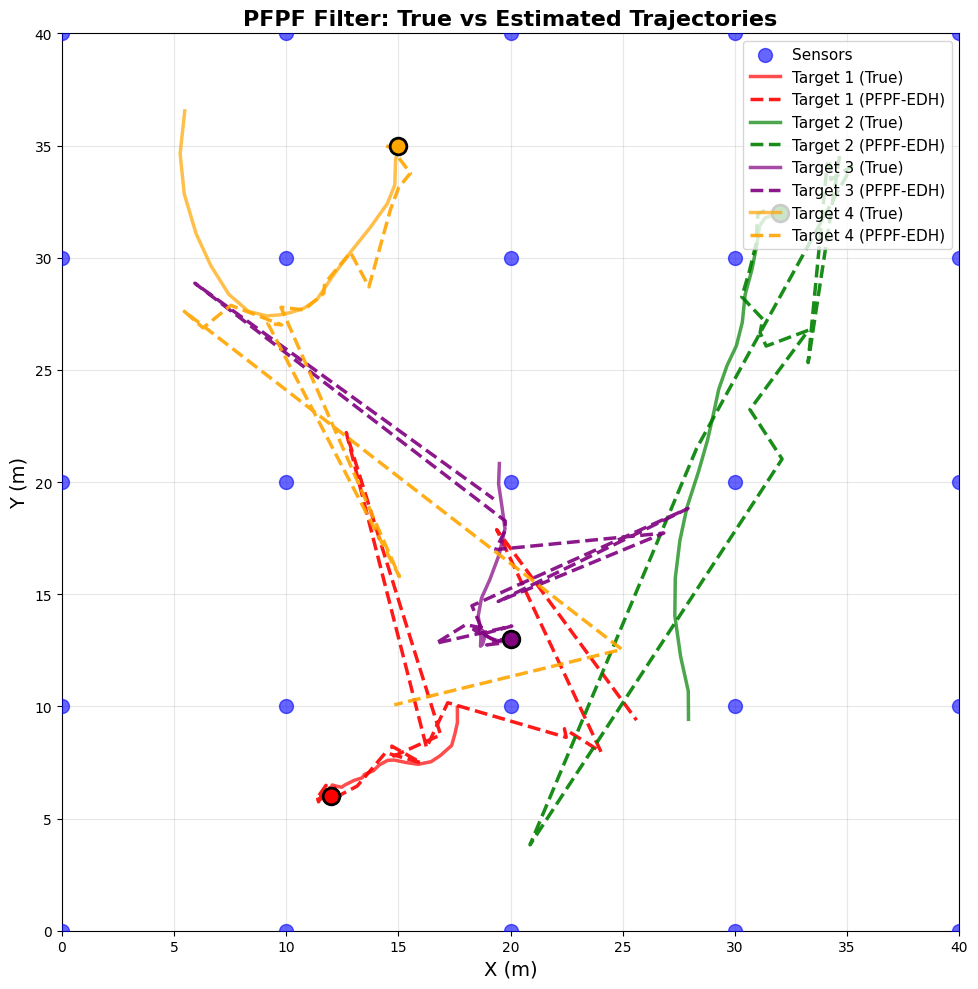

In [9]:
# Plot estimated trajectories
fig, ax = plt.subplots(figsize=(11, 10))

# Plot sensors
sensors = model_params['sensor_positions'].numpy()
ax.scatter(sensors[:, 0], sensors[:, 1], 
          c='blue', marker='o', s=100, label='Sensors', alpha=0.6, zorder=5)

colors = ['red', 'green', 'purple', 'orange']
gt = ground_truth.numpy()
est = estimates.numpy()

for i in range(model_params['n_targets']):
    x_idx = i * 4
    y_idx = i * 4 + 1
    
    # Ground truth
    x_true = gt[x_idx, :]
    y_true = gt[y_idx, :]
    ax.plot(x_true, y_true, '-', color=colors[i], linewidth=2.5,
           label=f'Target {i+1} (True)', alpha=0.7)
    
    # Estimates
    x_est = est[x_idx, :]
    y_est = est[y_idx, :]
    ax.plot(x_est, y_est, '--', color=colors[i], linewidth=2.5,
           label=f'Target {i+1} (PFPF-EDH)', alpha=0.9, linestyle='dashed')
    
    # Mark start
    ax.plot(x_true[0], y_true[0], 'o', color=colors[i], 
           markersize=12, markeredgecolor='black', markeredgewidth=2)

ax.set_xlabel('X (m)', fontsize=14)
ax.set_ylabel('Y (m)', fontsize=14)
ax.set_title('PFPF Filter: True vs Estimated Trajectories', fontsize=16, fontweight='bold')
ax.legend(fontsize=11, loc='upper right')
ax.grid(True, alpha=0.3)
ax.set_xlim([0, model_params['sim_area_size']])
ax.set_ylim([0, model_params['sim_area_size']])
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

## 8. Summary: Function-to-Algorithm Mapping

| Function | Algorithm Lines | Purpose |
|----------|----------------|----------|
| `compute_lambda_steps()` | Pre-processing | Exponential spacing for lambda |
| `initialize_particles()` | 1-2 | Draw particles from prior and set weights |
| `propagate_particles()` | 7 (LEDH) / 6 (EDH) | Motion model prediction |
| `estimate_covariance()` | 5 (LEDH) / 4 (EDH) | Compute covariance from particles |
| `compute_flow_parameters()` | 16 (LEDH) / 13 (EDH) | Compute A(λ) and b(λ) |
| `particle_flow_ledh()` | 11-21 (LEDH) | Migrate particles with local linearization |
| `particle_flow_edh()` | 10-18 (EDH) | Migrate particles with global linearization |
| `compute_likelihood()` | 24 (LEDH) / 21 (EDH) | Compute p(z_k\|x_k) for weights |
| `pfpf_ledh_filter_step()` | 4-29 (LEDH) | One complete LEDH iteration |
| `pfpf_edh_filter_step()` | 4-27 (EDH) | One complete EDH iteration |
| `run_pfpf_filter()` | 1-30 (LEDH) / 1-27 (EDH) | Full filter on sequence |

### Key Points:

1. **Invertible Mapping Property**:
   - LEDH: Weight update includes determinant term $\theta^i = \prod_j |\det(I + \epsilon_j A_j^i(\lambda))|^{-1}$
   - EDH: No determinant needed because same mapping for all particles

2. **Weight Update**:
   - LEDH: $w_k^i \propto \frac{p(x_k^i|x_{k-1}^i)p(z_k|x_k^i)\theta^i}{p(\eta_0^i|x_{k-1}^i)} w_{k-1}^i$
   - EDH: $w_k^i \propto \frac{p(x_k^i|x_{k-1}^i)p(z_k|x_k^i)}{p(\eta_0^i|x_{k-1}^i)} w_{k-1}^i$

3. **Computational Complexity**:
   - LEDH: $O(N_p S^3 N_\lambda)$ - expensive due to per-particle flow
   - EDH: $O(S^3 N_\lambda + N_p)$ - much faster, shared flow parameters

4. **Theoretical Guarantees**:
   - PFPF maintains particle filter convergence guarantees
   - Particle flow constructs good proposal distribution
   - Weight update corrects for flow approximations